In [1]:
#basic package
import os
import numpy as np
import pandas as pd
import sys
import time
import datetime as dt
import itertools
import math
import pickle #save and load dictionaries/lists
import random
import tqdm

#plot
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\camil\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\camil\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\camil\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
PACKAGE_PARENT = '../'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd(), os.path.expanduser('__file__'))))
sys.path.append(os.path.normpath(os.path.join(SCRIPT_DIR, PACKAGE_PARENT)))
from UTILS import nbrh_WG_open, mid_cum_Z4_sec, starting_h_day
import config_origins as config

C:\Users\camil\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex
C:\Users\camil\anaconda3\lib\site-packages\gensim\matutils.py:24: DeprecationWarning: Please use `triu` from the `scipy.linalg` namespace, the `scipy.linalg.special_matrices` namespace is deprecated.
  from scipy.linalg.special_matrices import triu
C:\Users\camil\anaconda3\lib\site-packages\xgboost\compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


2


In [3]:
name = 'OFH'

# Define parameters

In [4]:
print('change the configuration file if not done yet!')
path_extracted_data = config.path_extracted_data
id_run = config.id_run
max_date_adaptability = config.max_date_adaptability
pal_tr = config.pal_treat

change the configuration file if not done yet!


# Download data

In [5]:
### daily variables of the movements (one row per available hen per day)
df_daily = pd.read_csv(os.path.join(path_extracted_data, id_run+'_daily_ALL_variables_verified_OFH.csv'), sep=';',
                     parse_dates=['level'], dayfirst=True)
#display(df_daily[df_daily.isna().any(axis=1)])

#make sure we have their mvt
df_daily = df_daily[~df_daily['perc_duration_5_Zone'].isnull()]
display(df_daily['CLASS'].value_counts())
#show columns with max amount of nan
display(df_daily.isna().sum(axis=0).sort_values())
print(df_daily.shape)
display(df_daily.head(3))

#look at the timeframe
print(min(df_daily['WOA'].tolist()), max(df_daily['WOA'].tolist()))
df_doa = df_daily[['level','DIB','WIB','DOA','WOA']].drop_duplicates()
df_doa.sort_values(['level']).head(10)

#remove vaccinations days
x0 = df_daily.shape[0]
df_daily = df_daily[df_daily['is_vacc']==False]
print('you lost %s observations by removing days with vaccinations'%(x0-df_daily.shape[0]))

#check that its nan for the first 16 days in the barn
if df_daily[(df_daily['level']<=dt.datetime(2020,10,15))&(~df_daily['mid_cum_Z4_h_Morning'].isnull())].shape[0]!=0:
    print('ERROR: you should have only nan in the mid-nestbox tier behaviour before the 15th of october 2020, due to the \
    artificial light beeing turned on no earlier tha 8am')
    sys.exit()

df_daily.loc[df_daily['nbr_stays_1_Zone'].isnull(),'WentinWG'] = np.nan
print(df_daily.columns)

REXP    22507
MEXP     9067
LEXP     7358
Name: CLASS, dtype: int64

HenID                                                0
CLASS                                                0
InitialStartDate                                     0
early_death                                          0
Treatment                                            0
                                                 ...  
mid_cum_Z4_sec_Morning                            5837
vertical_travel_distance_fulllight_perinsideh     6454
R-Pen                                            10923
FirstTimestamp_1_Zone                            14307
FirstTimestamp_1_Zone_sec                        14307
Length: 89, dtype: int64

(38932, 89)


,HenID,level,verification_daily_total_duration,verification_daily_total_nbr_hour,dur_values,perc_duration_3_Zone,perc_duration_4_Zone,perc_duration_5_Zone,perc_duration_2_Zone,perc_duration_1_Zone,...,duration_4_Zone_min,duration_5_Zone_min,Has_been_toptier_wholeday,level_,vertical_travel_distance_perinsideh,day_lighth,mid_durationafterlightturnedon_Z4_h_Morning,previous_mid_cum_Z4_h_Morning,Intervaltime_midcumZ4hmorning_h,is_vacc
0,hen_130,2020-10-05,32400.0,9.0,"[0.0, 0.0, 0.0, 0.0, 32400.0]",0.0,0.0,100.0,0.0,NaN,...,0.000000,540.000000,True,2020-10-05,0.000000,9,NaN,NaN,NaN,False
1,hen_130,2020-10-06,32400.0,9.0,"[0.0, 0.0, 780.0, 325.0, 31295.0]",2.0,1.0,97.0,0.0,NaN,...,5.416667,521.583333,False,2020-10-06,0.444444,9,NaN,NaN,NaN,False
2,hen_130,2020-10-07,32400.0,9.0,"[0.0, 206.0, 249.0, 130.0, 31815.0]",1.0,0.0,98.0,1.0,NaN,...,2.166667,530.250000,False,2020-10-07,0.444444,9,NaN,NaN,NaN,False


17 60
you lost 471 observations by removing days with vaccinations
Index(['HenID', 'level', 'verification_daily_total_duration',
       'verification_daily_total_nbr_hour', 'dur_values',
       'perc_duration_3_Zone', 'perc_duration_4_Zone', 'perc_duration_5_Zone',
       'perc_duration_2_Zone', 'perc_duration_1_Zone', 'time_wg_open_sec',
       'duration_sincedaystarted_beforeWGopened_sec',
       'perc_1_Zone_while_WG_open', 'FirstTimestamp_1_Zone',
       'FirstTimestamp_2_Zone', 'FirstTimestamp_3_Zone',
       'FirstTimestamp_4_Zone', 'FirstTimestamp_5_Zone', 'nbr_h_WGopen',
       'FirstTimestamp_1_Zone_sec', 'latency_1_Zone_h', 'Total_number_zone',
       'list_of_durations', 'nestboxes_related_behavior', 'mid_cum_Z4_sec',
       'Total_number_transition', 'nbr_stays', 'distribution_entropy',
       'vertical_travel_distance', 'vertical_travel_distance_dawn',
       'vertical_travel_distance_dusk', 'nbr_stays_total', 'nbr_stays_3_Zone',
       'nbr_stays_4_Zone', 'nbr_stays_5_Zon

In [7]:
#select & keep only variables we are interested in
li = ['HenID','PenID','level','Treatment', 'CLASS', 'DOA','WOA', 'DIB','WIB','weight_interp','FeatherDamage_interp','KBF_interp','weekday','is_vacc']
li_mvt = ['WentinWG','vertical_travel_distance','mid_cum_Z4_h_Morning','nbr_h_WGopen','perc_duration_1_Zone',
         'perc_duration_4_Zone', 'perc_duration_5_Zone','perc_duration_2_Zone','nbr_h_per_day']
#if matts prefer: mid_durationafterlightturnedon_Z4_h_Morning, I dont
df_daily = df_daily[li+li_mvt].copy()
print(df_daily.shape)
df_daily.tail(3)

(38461, 23)


,HenID,PenID,level,Treatment,CLASS,DOA,WOA,DIB,WIB,weight_interp,...,is_vacc,WentinWG,vertical_travel_distance,mid_cum_Z4_h_Morning,nbr_h_WGopen,perc_duration_1_Zone,perc_duration_4_Zone,perc_duration_5_Zone,perc_duration_2_Zone,nbr_h_per_day
38929,hen_98,pen9,2021-07-22,OFH,MEXP,414,60,296,43,1755.238462,...,False,1.0,75.0,5.726944,8.333333,15.0,8.0,22.0,45.0,15
38930,hen_98,pen9,2021-07-23,OFH,MEXP,415,60,297,43,1755.392308,...,False,1.0,76.0,5.677778,8.333333,18.0,10.0,17.0,42.0,15
38931,hen_98,pen9,2021-07-24,OFH,MEXP,416,60,298,43,1755.546154,...,False,1.0,70.0,6.150278,8.333333,17.0,8.0,18.0,46.0,15


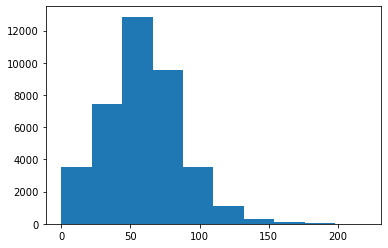

In [8]:
plt.hist(df_daily['vertical_travel_distance']);

In [9]:
#plt.hist(df_daily['Intervaltime_midcumZ4hmorning_h'], bins=30);
#plt.scatter(x='DIB', y='Intervaltime_midcumZ4hmorning_h', data=df_daily, alpha=0.1);

# Add external temperature

In [10]:
#add weather conditions
path_weather = os.path.join(r'C:\Users\camil\Desktop\vm_exchange\PhD_Data\Weather_exp1','Weather_process.csv')
df_weather_h = pd.read_csv(path_weather, sep=';', parse_dates=['date','Timestamp'])
df_weather_h = df_weather_h.sort_values('Timestamp') 
df_weather_h = df_weather_h.drop(['date'], axis=1)
df_weather_h['Timestamp_weather'] = df_weather_h['Timestamp'].copy()
print(df_weather_h.shape)
display(df_weather_h.head(2))

(7293, 13)


,Timestamp,temperature,humidity,wind speed,Precipitation amount,query,Moon Phase calculator,hour,temperature_C,wind_speed_mpers,humidity_avgpercent,rain,Timestamp_weather
0,2020-09-29 00:00:00,"10 °C\n(12:00 am CEST | Tuesday, September 29,...",average: 100% (100%)\n(12:00 am CEST | Tuesday...,"2 m/s\n(12:00 am CEST | Tuesday, September 29,...","rain\n(12:00 am CEST | Tuesday, September 29, ...","Moon Phase calculatorSeptember 29, 2020 0h",| waxing gibbous moon\n91.87% illuminated,0,10,2,100,rain,2020-09-29 00:00:00
1,2020-09-29 01:00:00,"10 °C\n(1:00 am CEST | Tuesday, September 29, ...","average: 100% (100%)\n(1:00 am CEST | Tuesday,...","3 m/s\n(1:00 am CEST | Tuesday, September 29, ...","rain\n(1:00 am CEST | Tuesday, September 29, 2...","Moon Phase calculatorSeptember 29, 2020 1h",| waxing gibbous moon\n92.09% illuminated,1,10,3,100,rain,2020-09-29 01:00:00


In [11]:
#add external temperature as environmental factor
#check variation over the day... exist very much
df_weather_h['date'] = df_weather_h['Timestamp'].map(lambda x: dt.datetime.date(x))
df_wday = df_weather_h[df_weather_h['hour'].isin([11,12,13,14,15,16])].groupby(['date'])['temperature_C'].agg(lambda x: list(x)).reset_index()
df_wday['temperature_C_avg'] = df_wday['temperature_C'].map(lambda x: np.mean(x))
display(df_wday.head(3))

print(df_daily.shape)
df_daily['date'] = df_daily['level'].map(lambda x: dt.datetime.date(x))
df_daily = pd.merge(df_daily, df_wday, on='date', how='left')
print(df_daily.shape)
df_daily.head(2)

,date,temperature_C,temperature_C_avg
0,2020-09-29,"[11, 12, 12, 12, 12, 13]",12.0
1,2020-09-30,"[10, 11, 13, 13, 14, 14]",12.5
2,2020-10-01,"[13, 15, 15, 15, 15, 14]",14.5


(38461, 23)
(38461, 26)


,HenID,PenID,level,Treatment,CLASS,DOA,WOA,DIB,WIB,weight_interp,...,mid_cum_Z4_h_Morning,nbr_h_WGopen,perc_duration_1_Zone,perc_duration_4_Zone,perc_duration_5_Zone,perc_duration_2_Zone,nbr_h_per_day,date,temperature_C,temperature_C_avg
0,hen_130,pen10,2020-10-05,TRAN,REXP,124,18,6,1,NaN,...,NaN,0.0,NaN,0.0,100.0,0.0,9,2020-10-05,"[10, 11, 12, 12, 12, 12]",11.5
1,hen_130,pen10,2020-10-06,TRAN,REXP,125,18,7,1,NaN,...,NaN,0.0,NaN,1.0,97.0,0.0,9,2020-10-06,"[11, 12, 14, 16, 13, 15]",13.5


# Save dataframe to assess effects of treatment

In [12]:
#proportion of INDOOR time
df_daily['perc_duration_1_Zone_nonan'] = df_daily['perc_duration_1_Zone'].fillna(0)
#if there is 100h over the day, and you spend 85h on Z5, and 3 hou outside then you spent 85/97*100 percent of your indoor time on Z5
#if oyu spen 15h outside then 85/85*100: 100% of oyur time on Z5
df_daily['propindoor_duration_5_Zone'] = df_daily.apply(lambda x: x['perc_duration_5_Zone']/(100-x['perc_duration_1_Zone_nonan']), axis=1)
df_daily['propindoor_duration_4_Zone'] = df_daily.apply(lambda x: x['perc_duration_4_Zone']/(100-x['perc_duration_1_Zone_nonan']), axis=1)
df_daily['propindoor_duration_2_Zone'] = df_daily.apply(lambda x: x['perc_duration_2_Zone']/(100-x['perc_duration_1_Zone_nonan']), axis=1)

#rescalling to 0.01-0.99 for beta
def renormalize(n, r1, r2):
    delta1 = r1[1] - r1[0] ; delta2 = r2[1] - r2[0]
    return (delta2 * (n - r1[0]) / delta1) + r2[0] #rescale from 0--1 then multiply by 99-1 and add 1
#small example:
#renormalize(99,[0,100], [1,99]) #98.02
#renormalize(0,[0,100], [1,99]) #1
df_daily['propindoor_duration_5_Zone_rs'] = df_daily['propindoor_duration_5_Zone'].map(lambda x: renormalize(x*100, [0,100], 
                                                                                                             [1,99])/100)
df_daily['propindoor_duration_4_Zone_rs'] = df_daily['propindoor_duration_4_Zone'].map(lambda x: renormalize(x*100, [0,100], 
                                                                                                             [1,99])/100)
df_daily['propindoor_duration_2_Zone_rs'] = df_daily['propindoor_duration_2_Zone'].map(lambda x: renormalize(x*100, [0,100], 
                                                                                                             [1,99])/100)

#small check 
display(df_daily[['propindoor_duration_5_Zone','propindoor_duration_5_Zone_rs',
          'propindoor_duration_4_Zone','propindoor_duration_4_Zone_rs']].tail(3))
print(df_daily['propindoor_duration_5_Zone_rs'].min(), df_daily['propindoor_duration_5_Zone_rs'].max(),
      df_daily['propindoor_duration_4_Zone_rs'].min(), df_daily['propindoor_duration_4_Zone_rs'].max())

#for month 1
df_daily['went_litter'] = df_daily['propindoor_duration_2_Zone'].map(lambda x: int(x>0))
display(df_daily['went_litter'].value_counts())
df_daily['stayed_top_tier'] = df_daily['propindoor_duration_5_Zone'].map(lambda x: int(x==1))
display(df_daily['stayed_top_tier'].value_counts())

,propindoor_duration_5_Zone,propindoor_duration_5_Zone_rs,propindoor_duration_4_Zone,propindoor_duration_4_Zone_rs
38458,0.258824,0.263647,0.094118,0.102235
38459,0.207317,0.213171,0.121951,0.129512
38460,0.216867,0.222530,0.096386,0.104458


0.01 0.99 0.01 0.99


1    37365
0     1096
Name: went_litter, dtype: int64

0    37989
1      472
Name: stayed_top_tier, dtype: int64

In [13]:
#remove this disfuntiocn tag
display(df_daily[df_daily['propindoor_duration_4_Zone']>=0.90].groupby('HenID')['DIB'].count().reset_index())
display(df_daily[df_daily['propindoor_duration_4_Zone']>=0.60].groupby('HenID')['DIB'].count().reset_index())

,HenID,DIB
0,hen_135,2
1,hen_199,7


,HenID,DIB
0,hen_116,1
1,hen_135,3
2,hen_143,1
3,hen_153,2
4,hen_156,1
5,hen_166,1
6,hen_174,1
7,hen_177,4
8,hen_199,28
9,hen_20,7


In [14]:
df_daily[df_daily['HenID']=='hen_199']['level'].max()
#01.02.2021 12.04.2021

Timestamp('2021-04-11 00:00:00')

In [15]:
df_daily[df_daily['HenID']=='hen_199']['level'].min()

Timestamp('2020-11-24 00:00:00')

In [16]:
#print(df_daily.shape)
#df_daily = df_daily[df_daily['HenID']!='hen_199']
#print(df_daily.shape)

#drop useless columns
print(df_daily.shape)
df_daily = df_daily.drop(['perc_duration_1_Zone','perc_duration_5_Zone','perc_duration_4_Zone','perc_duration_2_Zone','perc_duration_1_Zone_nonan',
               'temperature_C','is_vacc'], axis=1)
print(df_daily.shape)
df_daily.tail(3)

In [17]:
#df_ = df_daily[df_daily['DOA']>200].groupby(['DOA','date','Treatment'])['vertical_travel_distance'].mean().reset_index()
#plt.hist(df_['vertical_travel_distance']);
#df_[df_['vertical_travel_distance']>100]
#df_daily[df_daily['DOA']==275]['PenID'].value_counts()
#remove this weird distrubance day
print(df_daily.shape)
df_daily = df_daily[df_daily['DOA']!=275]
print(df_daily.shape)

(38461, 35)
(38303, 35)


In [18]:
df_ = df_daily.groupby('nbr_h_per_day')['DIB'].agg(lambda x: sorted(set(x))).reset_index()
display(df_)

,nbr_h_per_day,DIB
0,8,[1]
1,9,"[2, 3, 4, 5, 6, 7, 8]"
2,10,"[11, 12, 13, 14, 16]"
3,11,"[17, 18, 19, 20, 21, 22]"
4,12,"[23, 24, 25, 26, 27, 28, 29, 30]"
5,13,"[31, 32, 33, 34, 35, 36, 37]"
6,14,"[38, 39, 40, 41, 42, 43, 44]"
7,15,"[45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 56, 5..."


In [19]:
#df_daily['LPIB'] = df_daily['WIB'].map(lambda x: 'LP'+str(math.ceil(x/4)))
#display(df_daily.groupby(['LPIB'])['WIB'].agg(lambda x: set(x)).reset_index())
#month 9 (september) has only one day, lets include it in the first month
dico_month_ = {9:1,10:1,11:2,12:3,1:4,2:5,3:6,4:7,5:8,6:9,7:10}
df_daily['monthILB'] = df_daily['level'].map(lambda x:'month'+str(dico_month_[x.month]))
#small check
display(df_daily.groupby(['monthILB'])['level'].agg(lambda x: sorted(set(x))).reset_index())
df_daily['monthILB'].value_counts()

,monthILB,level
0,month1,"[2020-09-30 00:00:00, 2020-10-01 00:00:00, 202..."
1,month10,"[2021-07-04 00:00:00, 2021-07-05 00:00:00, 202..."
2,month2,"[2020-11-01 00:00:00, 2020-11-02 00:00:00, 202..."
3,month3,"[2020-12-01 00:00:00, 2020-12-02 00:00:00, 202..."
4,month4,"[2021-01-01 00:00:00, 2021-01-02 00:00:00, 202..."
5,month5,"[2021-02-03 00:00:00, 2021-02-04 00:00:00, 202..."
6,month6,"[2021-03-01 00:00:00, 2021-03-02 00:00:00, 202..."
7,month7,"[2021-04-01 00:00:00, 2021-04-02 00:00:00, 202..."
8,month8,"[2021-05-01 00:00:00, 2021-05-02 00:00:00, 202..."
9,month9,"[2021-06-01 00:00:00, 2021-06-03 00:00:00, 202..."


month8     4552
month3     4464
month2     4399
month6     4262
month7     4141
month1     3936
month5     3889
month4     3660
month10    3144
month9     1856
Name: monthILB, dtype: int64

In [20]:
df_daily.loc[df_daily['monthILB']=='month1','mid_cum_Z4_h_Morning'] = np.nan
df_daily.loc[df_daily['monthILB']=='month1','propindoor_duration_4_Zone_rs'] = np.nan
df_daily.loc[df_daily['monthILB']=='month1','propindoor_duration_4_Zone'] = np.nan

In [21]:
#plt.hist(df_daily[df_daily['monthILB']=='month1']['propindoor_duration_2_Zone_rs'], bins=50);

print(df_daily[(df_daily['monthILB']=='month1')&(df_daily['propindoor_duration_2_Zone']==0)].shape,
df_daily[(df_daily['monthILB']=='month1')&(df_daily['propindoor_duration_2_Zone']!=0)].shape)
print(df_daily[(df_daily['monthILB']=='month1')&(df_daily['propindoor_duration_5_Zone']==1)].shape,
df_daily[(df_daily['monthILB']=='month1')&(df_daily['propindoor_duration_5_Zone']!=1)].shape)

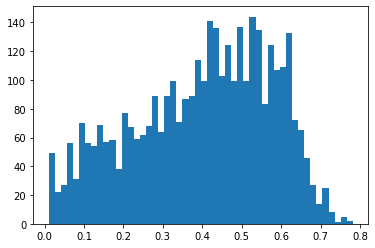

In [22]:
plt.hist(df_daily[df_daily['monthILB']=='month4']['propindoor_duration_2_Zone_rs'], bins=50);

In [23]:
df_daily.to_csv(os.path.join(path_extracted_data, name+'_df_all_mvt.csv'), index=False, sep=',')

df_ = df_daily.groupby(['HenID'])['propindoor_duration_2_Zone_rs'].mean().reset_index().sort_values('propindoor_duration_2_Zone_rs', ascending=False)
li_hen_ = df_['HenID'].tolist()
df_daily['order_D2'] = df_daily['HenID'].map(lambda x: li_hen_.index(x))
df_daily.sort_values('order_D2', inplace=True)
plt.figure(figsize=(15,5))
sns.boxplot(x='HenID', y='propindoor_duration_2_Zone_rs', data=df_daily[df_daily['monthILB']=='month3'], hue='HenID');

In [24]:
#sns.lineplot(x='DIB', y='propindoor_duration_4_Zone_rs', data=df_daily[df_daily['monthILB']=='month6'], hue='PenID')

df_ = df_daily[df_daily['monthILB']=='month5'].groupby('HenID')['monthILB'].count().reset_index().sort_values(['monthILB'])
display(df_.head(3))
li_henremove = df_[df_['monthILB']<5]['HenID'].unique()
print(len(li_henremove))
#save 
df_daily_ = df_daily[~df_daily['HenID'].isin(li_henremove)]
print(df_daily.shape, df_daily_.shape)
df_daily_.to_csv(os.path.join(path_extracted_data, name+'_df_all_mvt_henless.csv'), index=False, sep=',')

In [25]:
df_daily.isna().sum(axis=0).sort_values().tail(30)

perc_duration_1_Zone_nonan          0
date                                0
nbr_h_per_day                       0
perc_duration_2_Zone                0
perc_duration_5_Zone                0
perc_duration_4_Zone                0
stayed_top_tier                     0
vertical_travel_distance            0
nbr_h_WGopen                        0
is_vacc                             0
PenID                               0
level                               0
Treatment                           0
CLASS                               0
DOA                                 0
WOA                                 0
DIB                                 0
monthILB                            0
weekday                             0
WIB                                 0
KBF_interp                        277
temperature_C                     315
temperature_C_avg                 315
weight_interp                     848
FeatherDamage_interp             1320
WentinWG                         1714
perc_duratio

In [26]:
mi = min(df_daily['DOA'].tolist())
ma = max(df_daily['DOA'].tolist())
print('We are involving a period of %d days of tracking during the days from the DOA %d until DOA %d'%(ma-mi, mi, ma))

We are involving a period of 297 days of tracking during the days from the DOA 119 until DOA 416


In [27]:
#check #obs/hen - to be removed due to unexpected issues
df_info = df_daily.groupby(['HenID'])['DOA','level','PenID'].agg(lambda x: list(x)).reset_index()
df_info['nbrDaysTracked'] = df_info['DOA'].map(lambda x: len(set(x)))
df_info = df_info.sort_values(['nbrDaysTracked'])
display(df_info.head(3))
display(df_info.tail(3))
#pen 5 had issues with batteries of markers!
print(df_info['nbrDaysTracked'].mean())
#df_info[df_info['HenID']=='hen_26']['level'].values

print('hens had in average %d days tracked with a minimum of %d days tracked \
and a max of %d days'%(round(df_info['nbrDaysTracked'].mean(),0),df_info['nbrDaysTracked'].min(),df_info['nbrDaysTracked'].max()))

print('In other words, %d hens were used in subsequent analysis with a total of %d observations.'%(len(df_daily['HenID'].unique()),
                                                                                                   df_daily.shape[0]))

C:\Users\camil\AppData\Local\Temp/ipykernel_31796/3940579085.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_info = df_daily.groupby(['HenID'])['DOA','level','PenID'].agg(lambda x: list(x)).reset_index()


,HenID,DOA,level,PenID,nbrDaysTracked
34,hen_130,"[124, 125, 126]","[2020-10-05 00:00:00, 2020-10-06 00:00:00, 202...","[pen10, pen10, pen10]",3
36,hen_132,"[119, 120, 121, 125, 126]","[2020-09-30 00:00:00, 2020-10-01 00:00:00, 202...","[pen8, pen8, pen8, pen8, pen8]",5
152,hen_31,"[119, 120, 121, 125, 126]","[2020-09-30 00:00:00, 2020-10-01 00:00:00, 202...","[pen9, pen9, pen9, pen9, pen9]",5


,HenID,DOA,level,PenID,nbrDaysTracked
191,hen_67,"[119, 120, 121, 123, 124, 125, 126, 129, 130, ...","[2020-09-30 00:00:00, 2020-10-01 00:00:00, 202...","[pen10, pen10, pen10, pen10, pen10, pen10, pen...",250
148,hen_28,"[119, 120, 121, 123, 124, 125, 126, 129, 130, ...","[2020-09-30 00:00:00, 2020-10-01 00:00:00, 202...","[pen11, pen11, pen11, pen11, pen11, pen11, pen...",250
190,hen_66,"[119, 120, 121, 125, 126, 129, 130, 131, 132, ...","[2020-09-30 00:00:00, 2020-10-01 00:00:00, 202...","[pen8, pen8, pen8, pen8, pen8, pen8, pen8, pen...",250


168.73568281938327
hens had in average 169 days tracked with a minimum of 3 days tracked and a max of 250 days
In other words, 227 hens were used in subsequent analysis with a total of 38303 observations.


# Save dataframe for HA

In [28]:
#all
df_HA = pd.read_csv(os.path.join(path_extracted_data, 'df_all_HA.csv'), sep=';')
df_HA['FeatherDamage'] = df_HA['Feathers'].map(lambda x: 100-x)
display(df_HA['CLASS'].value_counts())
df_HA['CLASS'] = df_HA['CLASS'].map(lambda x: 'REXP' if x not in ['MEXP','LEXP'] else x)
display(df_HA['CLASS'].value_counts())
print(df_HA.shape) 
display(df_HA.head(3))

Other    507
MEXP     188
LEXP     149
Name: CLASS, dtype: int64

REXP    509
MEXP    188
LEXP    149
Name: CLASS, dtype: int64

(846, 59)


,Person_toe,Time,PenID,FocalLegringName,BirdType,CombPecks,Toes,RFPododermatitis,RFBumblefoot,RFinjuries,...,imageID,random_order1,severity,has_gap,BirdID,uncertainty (0:certain:1 random),Unnamed: 9,Info,backpack,FeatherDamage
0,M,09:30,pen9,42grey,normal,25.0,NaN,0.0,0.0,0.0,...,239.0,109.0,0,0.0,42grey9sb,NaN,NaN,"['', '42', 'grey', '9', 'sb']",sb,NaN
1,Mark,14:54,pen9,66grey,normal,0.0,NaN,50.0,0.0,0.0,...,456.0,509.0,16,0.0,66grey9sp,NaN,NaN,"['', '66', 'grey', '9', 'sp']",sp,14.0
2,Camille,10:30,pen5,2green,normal,130.0,NaN,25.0,0.0,0.0,...,482.0,428.0,4,0.0,2green5pp,NaN,NaN,"['', '2', 'green', '5', 'pp']",pp,8.0


In [29]:
df_HA.isna().sum(axis=0).sort_values().tail(30)
print(df_HA.shape)
df_HA = df_HA[~df_HA['Treatment'].isnull()][['CLASS','date','Treatment','HenID','severity','FeatherDamage','DOA','PenID']]
print(df_HA.shape)
df_HA.isna().sum(axis=0).sort_values().tail(30)

(846, 59)
(844, 8)


CLASS              0
date               0
Treatment          0
HenID              0
severity           0
DOA                0
PenID              0
FeatherDamage    181
dtype: int64

In [30]:
display(df_daily['CLASS'].value_counts())

REXP    22141
MEXP     8922
LEXP     7240
Name: CLASS, dtype: int64

In [31]:
sorted(df_HA['DOA'].unique())

[173.0, 215.0, 243.0, 313.0, 417.0]

In [32]:
#median of 0 over 100
df_HA[df_HA['DOA']==173]['severity'].describe()

count    175.000000
mean       6.788571
std       12.321175
min        0.000000
25%        0.000000
50%        0.000000
75%       10.000000
max       66.000000
Name: severity, dtype: float64

In [33]:
#median of 0 over 100
df_HA[df_HA['DOA']==215]['FeatherDamage'].describe()

count    157.000000
mean       3.106157
std        4.604135
min        0.000000
25%        0.000000
50%        0.333333
75%        5.000000
max       20.666667
Name: FeatherDamage, dtype: float64

In [34]:
#save
df_HA.to_csv(os.path.join(path_extracted_data, name+'_df_HA.csv'), index=False, sep=',')

# Save dataframe for growth curve

In [35]:
#focal birds information (one row per focal bird)
df_FB = pd.read_csv(os.path.join(path_extracted_data, id_run+'df_FOCALBIRDS.csv'), sep=';', parse_dates=['InitialStartDate'])
df_FB['early_death'] = df_FB['early_death'].fillna(0).replace(2,1) #2 means not sure
display(df_FB['early_death'].value_counts())
dico_cl = {'EPI':'REXP', 'NewAfterEpi':'REXP', 'MEXP':'MEXP', 'LEXP':'LEXP', 'LEXPLOST':'REXP', 'MEXPLOST':'REXP', 'NewAfterEpiLOST':'REXP'}
df_FB['CLASS'] = df_FB['CLASS'].map(lambda x: dico_cl[x])
display(df_FB['CLASS'].value_counts())
print(df_FB.shape)
df_FB.head(3)

0.0    222
1.0     10
Name: early_death, dtype: int64

REXP    162
MEXP     39
LEXP     31
Name: CLASS, dtype: int64

(232, 14)


,HenID,PenID,CLASS,R-Pen,InitialStartDate,early_death,29-09 weight,10-12 juin weight,weight 23-11-2020,weight 04-01-2021,weight 01-02-21,weight 12-04-21,weight 26-07-21,Treatment
0,hen_1,9,REXP,1.0,2020-06-10,0.0,1134.0,57.0,1696.5,1787.8,1800.9,NaN,NaN,OFH
1,hen_10,11,LEXP,1.0,2020-06-10,0.0,1070.0,70.4,1488.3,1628.4,1602.1,1587.2,1713.4,OFH
2,hen_100,5,REXP,3.0,2020-06-10,0.0,1182.0,80.5,1642.5,NaN,NaN,NaN,NaN,OFH


In [36]:
#already NA in the 10-12 juin so it means its on the 10th all, i.e. DOA 7
df_FB[df_FB['InitialStartDate']==dt.datetime(2020,6,12)]

,HenID,PenID,CLASS,R-Pen,InitialStartDate,early_death,29-09 weight,10-12 juin weight,weight 23-11-2020,weight 04-01-2021,weight 01-02-21,weight 12-04-21,weight 26-07-21,Treatment
18,hen_115,3,LEXP,3.0,2020-06-12,0.0,1130.0,NaN,1705.4,1717.4,1787.7,1861.7,1845.9,OFH
19,hen_116,9,LEXP,3.0,2020-06-12,0.0,1190.0,NaN,1606.1,1796.4,1878.9,1952.3,2022.1,OFH
20,hen_117,11,REXP,3.0,2020-06-12,0.0,1158.0,NaN,1632.2,NaN,NaN,NaN,NaN,OFH
21,hen_118,11,REXP,3.0,2020-06-12,0.0,1144.0,NaN,1540.0,1693.9,1687.5,1755.2,1759.3,OFH
22,hen_119,5,LEXP,3.0,2020-06-12,0.0,1200.0,NaN,1707.4,1788.6,1806.5,1988.4,2000.8,OFH
24,hen_120,9,LEXP,3.0,2020-06-12,0.0,1204.0,NaN,1642.3,1722.8,1772.7,1819.5,1820.9,OFH
156,hen_30,3,REXP,1.0,2020-06-12,0.0,1154.0,NaN,NaN,NaN,NaN,NaN,NaN,OFH
159,hen_33,11,REXP,1.0,2020-06-12,0.0,1208.0,NaN,NaN,NaN,NaN,NaN,NaN,OFH
160,hen_34,5,REXP,1.0,2020-06-12,0.0,1218.0,NaN,1639.3,1720.5,1749.7,NaN,NaN,OFH
161,hen_35,5,REXP,1.0,2020-06-12,0.0,1240.0,NaN,NaN,NaN,NaN,NaN,NaN,OFH


df_FB['12 juin weight'] = df_FB.apply(lambda x: x['10-12 juin weight'] if x['InitialStartDate']==dt.datetime(2020,6,12) else np.nan, axis=1)
df_FB['10 juin weight'] = df_FB.apply(lambda x: x['10-12 juin weight'] if x['InitialStartDate']==dt.datetime(2020,6,10) else np.nan, axis=1)
df_FB[['12 juin weight','10 juin weight','10-12 juin weight']]
#we did not weight them on the 12th!
df_FB[df_FB['InitialStartDate']==dt.datetime(2020,6,12)]

In [37]:
df_FB['InitialStartDate'].value_counts()

2020-06-10    133
2020-11-23     18
2020-06-12     17
2021-04-12     17
2021-02-01     16
2020-10-08     15
2020-09-29     10
2020-10-13      1
2020-10-20      1
2020-10-30      1
2021-02-08      1
2021-02-22      1
2020-06-17      1
Name: InitialStartDate, dtype: int64

In [38]:
#save file for OFH chapter to use in R to fit growth curve
df_FB['PenID'] = df_FB['PenID'].map(lambda x: 'pen_'+str(x))
df_FB['PenID'].unique()

array(['pen_9', 'pen_11', 'pen_5', 'pen_3', 'pen_12', 'pen_4', 'pen_8',
       'pen_10'], dtype=object)

In [39]:
li_weight = [i for i in df_FB.columns if ('weight' in i)]
print(li_weight)
df_FB_ = pd.melt(df_FB, id_vars=['HenID','Treatment','CLASS','PenID','R-Pen'], value_vars=li_weight, value_name = 'weight')
df_FB_.head(3)

['29-09 weight', '10-12 juin weight', 'weight 23-11-2020', 'weight 04-01-2021', 'weight 01-02-21', 'weight 12-04-21', 'weight 26-07-21']


,HenID,Treatment,CLASS,PenID,R-Pen,variable,weight
0,hen_1,OFH,REXP,pen_9,1.0,29-09 weight,1134.0
1,hen_10,OFH,LEXP,pen_11,1.0,29-09 weight,1070.0
2,hen_100,OFH,REXP,pen_5,3.0,29-09 weight,1182.0


In [40]:
dico_name_date = {'29-09 weight':dt.datetime(2020,9,29), 
                  '10-12 juin weight':dt.datetime(2020,6,10), #we did not weight them on the 12th!
                  'weight 23-11-2020':dt.datetime(2020,11,23), 
                  'weight 04-01-2021':dt.datetime(2021,1,4), 
                  'weight 01-02-21':dt.datetime(2021,2,1), 
                  'weight 12-04-21':dt.datetime(2021,4,12), 
                  'weight 26-07-21':dt.datetime(2021,7,25)} #we did it on the 25 actually
df_FB_['date'] = df_FB_['variable'].map(lambda x:dico_name_date[x])
df_FB_['DOA'] = df_FB_['date'].map(lambda x: (x-dt.datetime(2020,6,3)).days) 
df_FB_ = df_FB_.sort_values('DOA')
print(df_FB_.shape)
df_FB_.head(3)

(1624, 9)


,HenID,Treatment,CLASS,PenID,R-Pen,variable,weight,date,DOA
405,hen_46,TRAN,REXP,pen_10,2.0,10-12 juin weight,63.6,2020-06-10,7
316,hen_175,TRAN,REXP,pen_12,NaN,10-12 juin weight,NaN,2020-06-10,7
315,hen_174,TRAN,REXP,pen_4,NaN,10-12 juin weight,NaN,2020-06-10,7


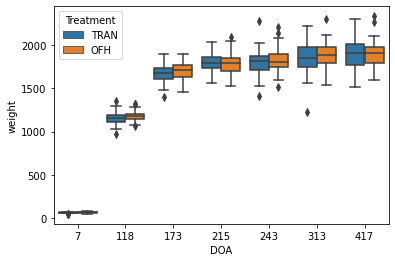

In [41]:
#plt.figure(figsize=(10,10))
#sns.lineplot(x='DOA',y='weight',hue='Treatment', data=df_FB_);
sns.boxplot(x='DOA',y='weight',hue='Treatment', data=df_FB_);

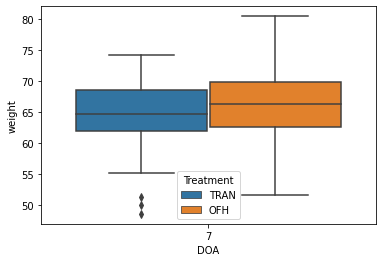

In [42]:
sns.boxplot(x='DOA',y='weight',hue='Treatment', data=df_FB_[df_FB_['DOA']==7]);

In [43]:
df_FB_.head(3)

,HenID,Treatment,CLASS,PenID,R-Pen,variable,weight,date,DOA
405,hen_46,TRAN,REXP,pen_10,2.0,10-12 juin weight,63.6,2020-06-10,7
316,hen_175,TRAN,REXP,pen_12,NaN,10-12 juin weight,NaN,2020-06-10,7
315,hen_174,TRAN,REXP,pen_4,NaN,10-12 juin weight,NaN,2020-06-10,7


In [44]:
#normalising distinctiveness per degree for the triangle network
type_ = 'weight'
li_df = []
print(df_FB_.shape)
for comp,df_FB__ in tqdm.tqdm(df_FB_.groupby('date')):
    df_FB__[type_+'_norm'] = (df_FB__['weight']-df_FB__['weight'].min())/(df_FB__['weight'].max()-df_FB__['weight'].min())
    li_df.append(df_FB__)
df_FB_F = pd.concat(li_df)
print(df_FB_F.shape)
df_FB_F.head(3)

(1624, 9)


100%|██████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 1403.78it/s]

(1624, 10)


,HenID,Treatment,CLASS,PenID,R-Pen,variable,weight,date,DOA,weight_norm
405,hen_46,TRAN,REXP,pen_10,2.0,10-12 juin weight,63.6,2020-06-10,7,0.470219
316,hen_175,TRAN,REXP,pen_12,NaN,10-12 juin weight,NaN,2020-06-10,7,NaN
315,hen_174,TRAN,REXP,pen_4,NaN,10-12 juin weight,NaN,2020-06-10,7,NaN


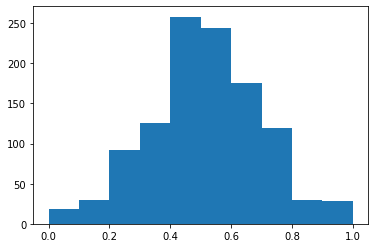

In [45]:
plt.hist(df_FB_F['weight_norm']);

In [46]:
df_FB_F = df_FB_F[~df_FB_F['weight'].isnull()]
print(df_FB_F.shape)
df_FB_F.to_csv(os.path.join(path_extracted_data, 'OFH_df_FOCALBIRDS.csv'), index=False, sep=',')

(1121, 10)


# reopen small check

In [47]:
from scipy.stats import pearsonr, spearmanr

In [48]:
df = pd.read_csv(os.path.join(path_extracted_data, name+'_df_all_mvt.csv'), sep=',')
print(df.shape)
display(df.head(3))

(38303, 36)


,HenID,PenID,level,Treatment,CLASS,DOA,WOA,DIB,WIB,weight_interp,...,perc_duration_1_Zone_nonan,propindoor_duration_5_Zone,propindoor_duration_4_Zone,propindoor_duration_2_Zone,propindoor_duration_5_Zone_rs,propindoor_duration_4_Zone_rs,propindoor_duration_2_Zone_rs,went_litter,stayed_top_tier,monthILB
0,hen_130,pen10,2020-10-05,TRAN,REXP,124,18,6,1,NaN,...,0.0,1.00,NaN,0.00,0.9900,NaN,0.0100,0,1,month1
1,hen_130,pen10,2020-10-06,TRAN,REXP,125,18,7,1,NaN,...,0.0,0.97,NaN,0.00,0.9606,NaN,0.0100,0,0,month1
2,hen_130,pen10,2020-10-07,TRAN,REXP,126,18,8,2,NaN,...,0.0,0.98,NaN,0.01,0.9704,NaN,0.0198,1,0,month1


In [49]:
df__ = df[~df['temperature_C_avg'].isnull()]
for month_,df_ in df__.groupby('monthILB'):
    print(month_)
    print(spearmanr(df_['DIB'].tolist(), df_['temperature_C_avg'].tolist()))
    print(pearsonr(df_['DIB'].tolist(), df_['temperature_C_avg'].tolist()))

month1
SpearmanrResult(correlation=0.1334957987751729, pvalue=4.092903849420788e-17)
PearsonRResult(statistic=0.024123341302468126, pvalue=0.1302342549961459)
month10
SpearmanrResult(correlation=0.6077629257351489, pvalue=6.4420607e-317)
PearsonRResult(statistic=0.6343053621417453, pvalue=0.0)
month2
SpearmanrResult(correlation=-0.7532607541105913, pvalue=0.0)
PearsonRResult(statistic=-0.7906747542033394, pvalue=0.0)
month3
SpearmanrResult(correlation=0.21615606080961172, pvalue=2.3867998431063196e-48)
PearsonRResult(statistic=0.20355079189539593, pvalue=5.835399339782808e-43)
month4
SpearmanrResult(correlation=0.6372478329196734, pvalue=0.0)
PearsonRResult(statistic=0.6392578204792503, pvalue=0.0)
month5
SpearmanrResult(correlation=0.4211028765736844, pvalue=2.9799341473605614e-160)
PearsonRResult(statistic=0.39058055774697203, pvalue=3.353053205745251e-136)
month6
SpearmanrResult(correlation=0.21557060397603836, pvalue=5.4085254092358224e-46)
PearsonRResult(statistic=0.28713419733793

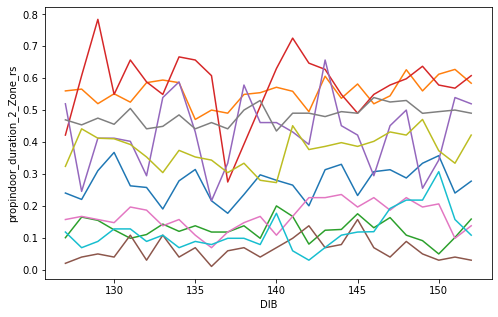

In [50]:
plt.figure(figsize=(8,5))
df_ = df[df['monthILB']=='month5']
li_hen = df_['HenID'].unique()
sns.lineplot(x='DIB',y='propindoor_duration_2_Zone_rs',hue='HenID', data=df_[df_['HenID'].isin(li_hen[0:10])], legend=False);

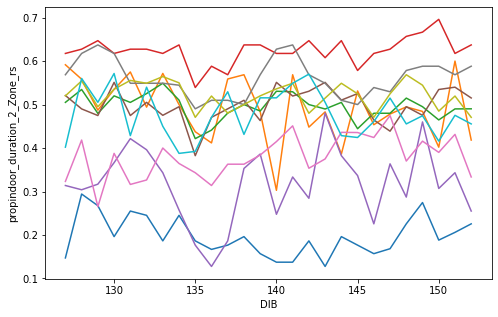

In [51]:
plt.figure(figsize=(8,5))
df_ = df[df['monthILB']=='month5']
li_hen = df_['HenID'].unique()
sns.lineplot(x='DIB',y='propindoor_duration_2_Zone_rs',hue='HenID', data=df_[df_['HenID'].isin(li_hen[10:20])], legend=False);

## add Rpen

In [10]:
#Rearing penid is in here
df_W = pd.read_csv(os.path.join(path_extracted_data, 'OFH_df_FOCALBIRDS.csv'), sep=',')
df_W.rename(columns={'R-Pen':'RPenID'}, inplace=True)
df_W.loc[(df_W['RPenID'].isnull())&(df_W['Treatment']=='OFH'), 'RPenID'] = '13'
df_W.loc[(df_W['RPenID'].isnull())&(df_W['Treatment']=='TRAN'), 'RPenID'] = '24'
df_W['RPenID'] = df_W['RPenID'].map(lambda x: 'Rpen'+str(int(x)))
df_W[df_W['RPenID'].isnull()]
print(df_W.shape) 
display(df_W.head(3))

(1121, 10)


,HenID,Treatment,CLASS,PenID,RPenID,variable,weight,date,DOA,weight_norm
0,hen_46,TRAN,REXP,pen_10,Rpen2,10-12 juin weight,63.6,2020-06-10,7,0.470219
1,hen_17,OFH,LEXP,pen_5,Rpen1,10-12 juin weight,60.4,2020-06-10,7,0.369906
2,hen_161,TRAN,REXP,pen_10,Rpen4,10-12 juin weight,66.7,2020-06-10,7,0.567398


In [11]:
#check
df_W.groupby('Treatment')[['Treatment','RPenID']].value_counts()

Treatment  RPenID
OFH        Rpen3     228
           Rpen1     209
           Rpen13    125
TRAN       Rpen2     225
           Rpen4     211
           Rpen24    123
dtype: int64

In [14]:
#add in mvt
df_mvt = pd.read_csv(os.path.join(path_extracted_data, 'OFH_df_all_mvt.csv'), sep=',')
print(df_mvt.shape) 
display(df_mvt.head(3))
df_mvt_ = pd.merge(df_mvt, df_W[['HenID','RPenID']].drop_duplicates(), on='HenID',how='left')
print(df_mvt.shape, df_mvt_.shape, df_W.shape)
df_mvt_.to_csv(os.path.join(path_extracted_data, 'OFH_df_all_mvt_.csv'), index=False, sep=',')

(38303, 36)


,HenID,PenID,level,Treatment,CLASS,DOA,WOA,DIB,WIB,weight_interp,...,perc_duration_1_Zone_nonan,propindoor_duration_5_Zone,propindoor_duration_4_Zone,propindoor_duration_2_Zone,propindoor_duration_5_Zone_rs,propindoor_duration_4_Zone_rs,propindoor_duration_2_Zone_rs,went_litter,stayed_top_tier,monthILB
0,hen_130,pen10,2020-10-05,TRAN,REXP,124,18,6,1,NaN,...,0.0,1.00,NaN,0.00,0.9900,NaN,0.0100,0,1,month1
1,hen_130,pen10,2020-10-06,TRAN,REXP,125,18,7,1,NaN,...,0.0,0.97,NaN,0.00,0.9606,NaN,0.0100,0,0,month1
2,hen_130,pen10,2020-10-07,TRAN,REXP,126,18,8,2,NaN,...,0.0,0.98,NaN,0.01,0.9704,NaN,0.0198,1,0,month1


(38303, 36) (38303, 37) (1121, 10)


In [15]:
#add in HA
df_HA = pd.read_csv(os.path.join(path_extracted_data, 'OFH_df_HA.csv'), sep=',')
print(df_HA.shape) 
display(df_HA.head(3))
df_HA_ = pd.merge(df_HA, df_W[['HenID','RPenID']].drop_duplicates(), on='HenID',how='left')
print(df_HA.shape, df_HA_.shape, df_W.shape)
df_HA_.to_csv(os.path.join(path_extracted_data, 'OFH_df_HA_.csv'), index=False, sep=',')

(844, 8)


,CLASS,date,Treatment,HenID,severity,FeatherDamage,DOA,PenID
0,REXP,2020-11-23,OFH,hen_164,0,NaN,173.0,pen9
1,REXP,2021-02-01,OFH,hen_181,16,14.0,243.0,pen9
2,REXP,2021-02-01,OFH,hen_82,4,8.0,243.0,pen5


(844, 8) (844, 9) (1121, 10)
